In [1]:
import nibabel as nib
from pathlib import Path
import torchio as tio
from PIL import Image
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation

/home/gridsan/nchutisilp/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
stent_label_dir = Path('stent_segmentations')
stent_input_dir = Path('stent_segmentations_input_image')
input_dir = Path('Sohee_Stent_Toy')
prediction_dir = Path('stent_segmentations_LaW_prediction')

stent_merged_label_dir = Path('stent_segmentations_merged')
stent_merged_label_dir.mkdir(exist_ok=True)

In [26]:
for i, folder in enumerate(input_dir.iterdir()):
    image_paths = [img_path for img_path in folder.glob('*.png')]
    if len(image_paths) == 0:
        continue
    image_paths.sort(key=lambda x: int(x.stem.split('_')[-1]))
    fname = folder.name
    images = []
    for image_path in image_paths:
        image = Image.open(image_path, mode='r')
        image = image.convert('L')
        image = np.array(image) / 256.0
        images.append(image)
    images = np.array(images).transpose(2, 1, 0)
    images = np.rot90(images, k=2, axes=(0, 1))
    images = nib.Nifti1Image(images, np.eye(4))
    nib.save(images, input_dir / f'{fname}.nii.gz')

In [34]:
fname = 'STENT'
map2label = dict()
stent_input_dir.mkdir(exist_ok=True)
for i, nii_path in enumerate(input_dir.glob('*.nii.gz')):
    img = nib.load(nii_path)
    nib.save(img, stent_input_dir / f'{fname}_{i:04d}_0000.nii.gz')
    map2label[nii_path.name] = f'{fname}_{i:04d}'
    print(nii_path , f'{fname}_{i:04d}_0000.nii.gz')

Sohee_Stent_Toy/101-56.nii.gz STENT_0000_0000.nii.gz
Sohee_Stent_Toy/101-26.nii.gz STENT_0001_0000.nii.gz
Sohee_Stent_Toy/AU_MON_00005.nii.gz STENT_0002_0000.nii.gz
Sohee_Stent_Toy/BE_OLV_00013.nii.gz STENT_0003_0000.nii.gz
Sohee_Stent_Toy/BE_OLV_00031.nii.gz STENT_0004_0000.nii.gz


In [44]:
map2label = {
    '101-56': 'STENT_0000',
    '101-26': 'STENT_0001',
    'AU_MON_00005': 'STENT_0002',
    'BE_OLV_00013': 'STENT_0003',
    'BE_OLV_00031': 'STENT_0004'}

In [48]:
fname = 'STENT'
stent_label_dir.mkdir(exist_ok=True)
stent_label_dir_list = [str(path) for path in stent_label_dir.glob('*.nii')]
stent_label_dir_list.sort()
stent_label_dir_list = [Path(path) for path in stent_label_dir_list]
for i, nii_path in enumerate(stent_label_dir.glob('*.nii')):
    img = nib.load(nii_path)
    save_name = f'{map2label[nii_path.stem]}.nii.gz'
    nib.save(img, stent_label_dir / save_name)
    print(nii_path , save_name)

stent_segmentations/101-56.nii STENT_0000.nii.gz
stent_segmentations/BE_OLV_00013.nii STENT_0003.nii.gz
stent_segmentations/AU_MON_00005.nii STENT_0002.nii.gz
stent_segmentations/BE_OLV_00031.nii STENT_0004.nii.gz
stent_segmentations/101-26.nii STENT_0001.nii.gz


In [18]:
prediction_dir_list, stent_label_dir_list

([PosixPath('stent_segmentations_LaW_prediction/STENT_0000.nii.gz'),
  PosixPath('stent_segmentations_LaW_prediction/STENT_0001.nii.gz'),
  PosixPath('stent_segmentations_LaW_prediction/STENT_0002.nii.gz'),
  PosixPath('stent_segmentations_LaW_prediction/STENT_0003.nii.gz'),
  PosixPath('stent_segmentations_LaW_prediction/STENT_0004.nii.gz')],
 [PosixPath('stent_segmentations_input_image/STENT_0000_0000.nii.gz'),
  PosixPath('stent_segmentations_input_image/STENT_0001_0000.nii.gz'),
  PosixPath('stent_segmentations_input_image/STENT_0002_0000.nii.gz'),
  PosixPath('stent_segmentations_input_image/STENT_0003_0000.nii.gz'),
  PosixPath('stent_segmentations_input_image/STENT_0004_0000.nii.gz')])

In [3]:
subjects = dict()

stent_input_dir_list = [str(path) for path in stent_input_dir.glob('*.nii.gz')]
stent_input_dir_list.sort()
stent_input_dir_list = [Path(path) for path in stent_input_dir_list]

stent_label_dir_list = [str(path) for path in stent_label_dir.glob('*.nii.gz')]
stent_label_dir_list.sort()
stent_label_dir_list = [Path(path) for path in stent_label_dir_list]

prediction_dir_list = [str(path) for path in prediction_dir.glob('*.nii.gz')]
prediction_dir_list.sort()
prediction_dir_list = [Path(path) for path in prediction_dir_list]
for i, (nii_path, label_path, pred_path) in enumerate(zip(stent_input_dir_list, stent_label_dir_list, prediction_dir_list)):
    subjects[nii_path.name] = tio.ScalarImage(nii_path)
    subjects['gt_' + label_path.name] = tio.LabelMap(label_path)
    subjects[pred_path.name] = tio.LabelMap(pred_path)
# tio.Subject(**subjects).plot(figsize=(25,15))

Merging Sohee's annotation of stent and lumen to the predictions of lumen and wall -> lumen and wall

STENT_0000_0000.nii.gz STENT_0000.nii.gz STENT_0000.nii.gz


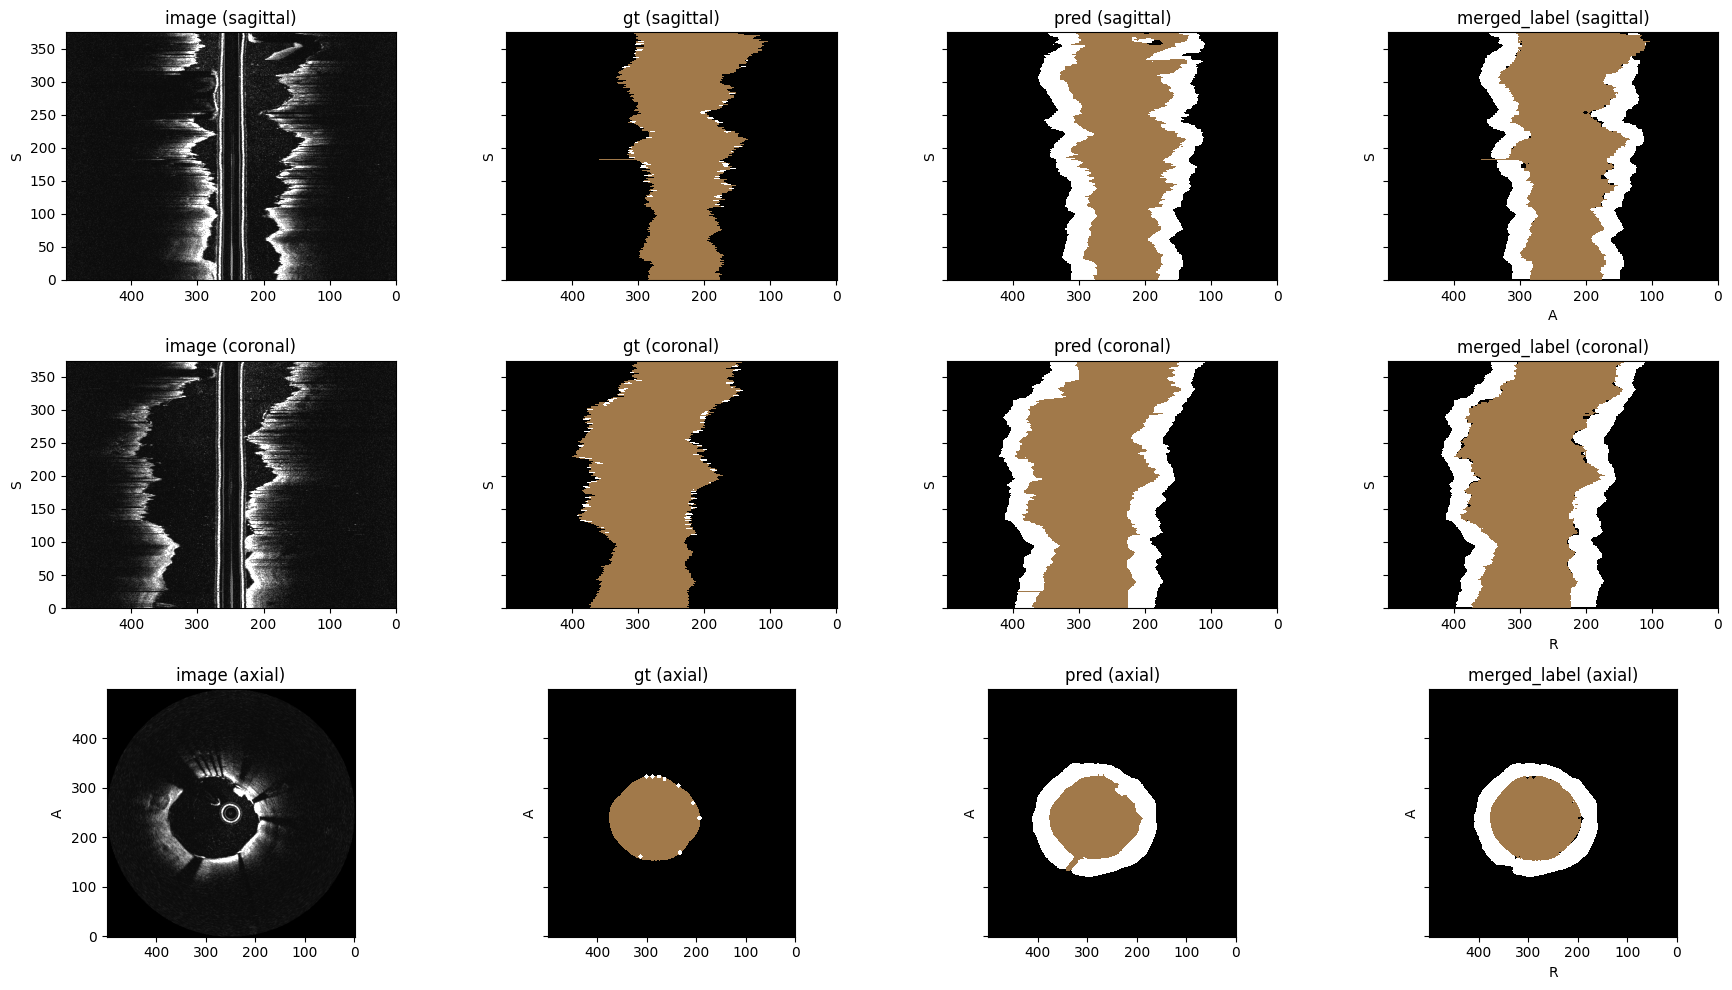

STENT_0001_0000.nii.gz STENT_0001.nii.gz STENT_0001.nii.gz


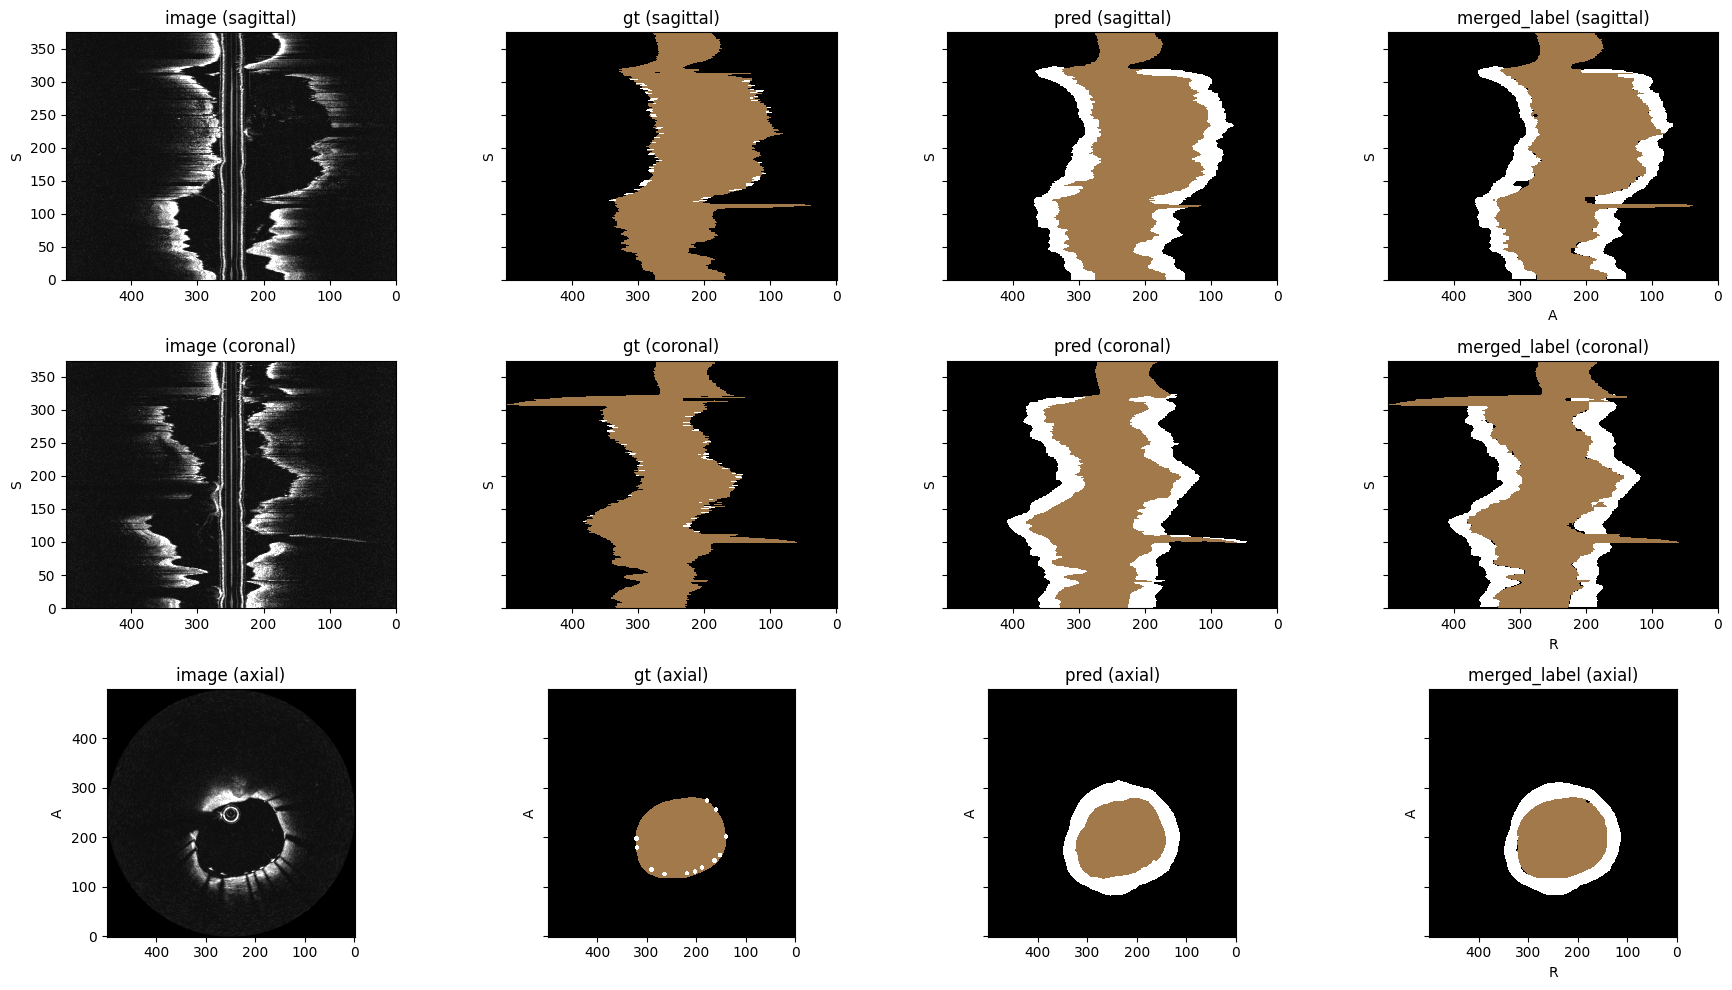

STENT_0002_0000.nii.gz STENT_0002.nii.gz STENT_0002.nii.gz


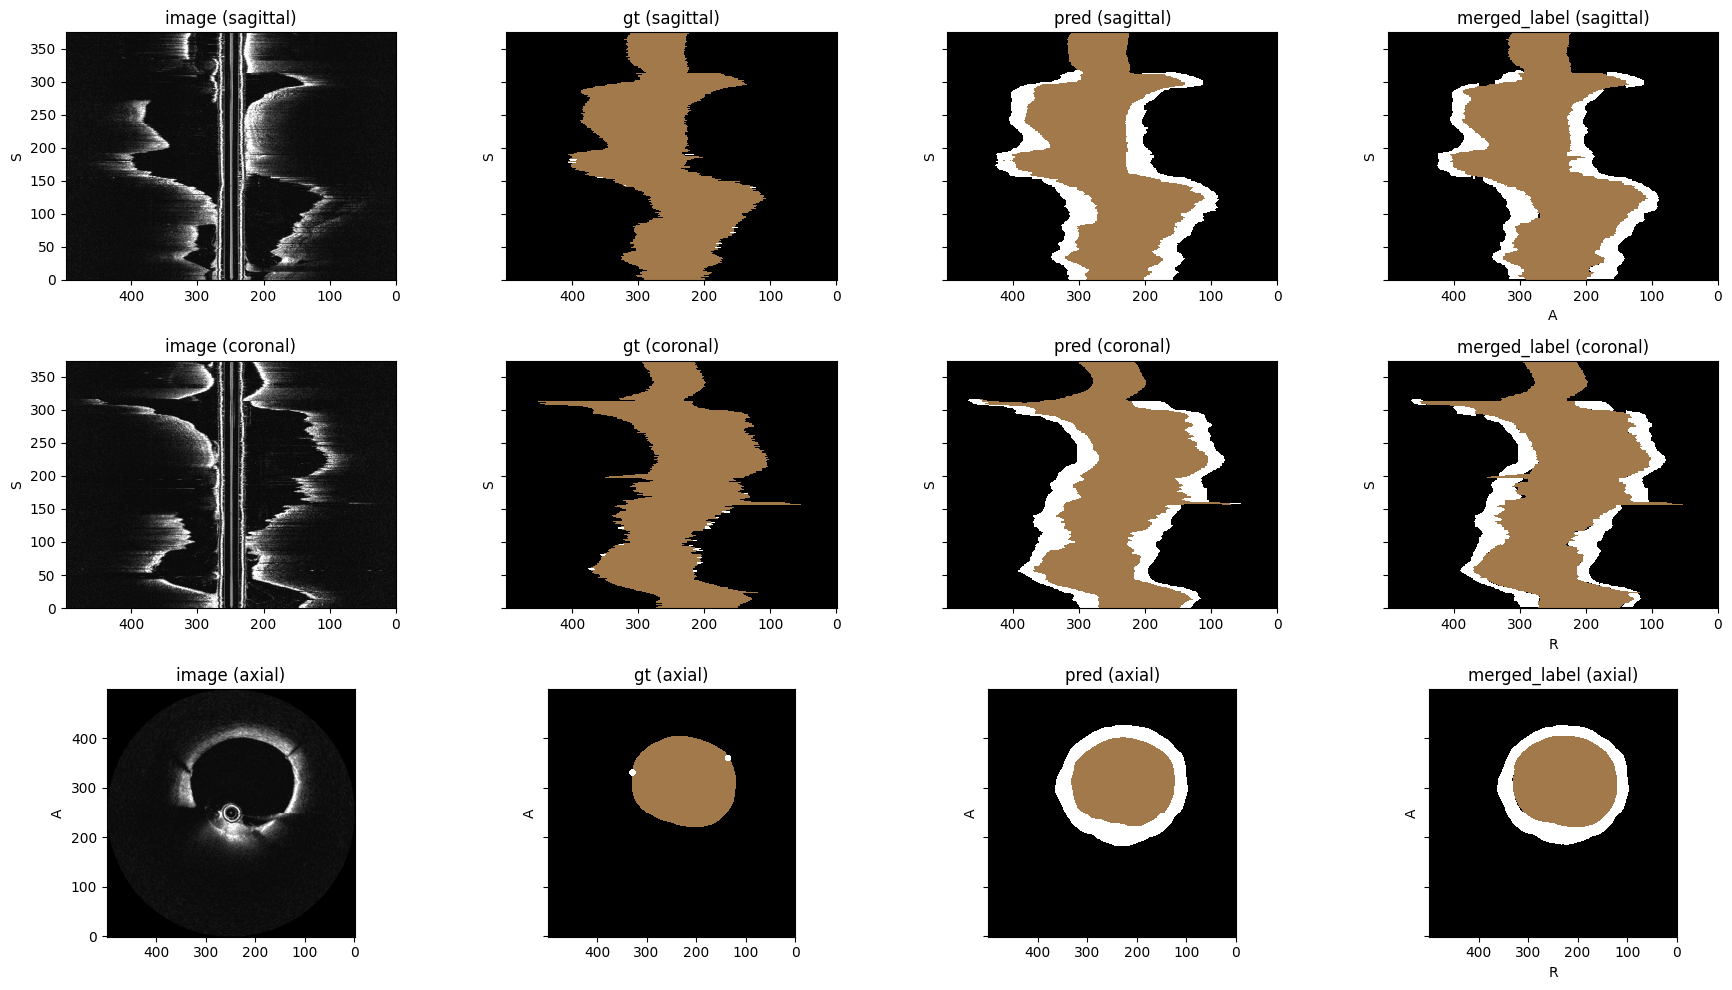

STENT_0003_0000.nii.gz STENT_0003.nii.gz STENT_0003.nii.gz


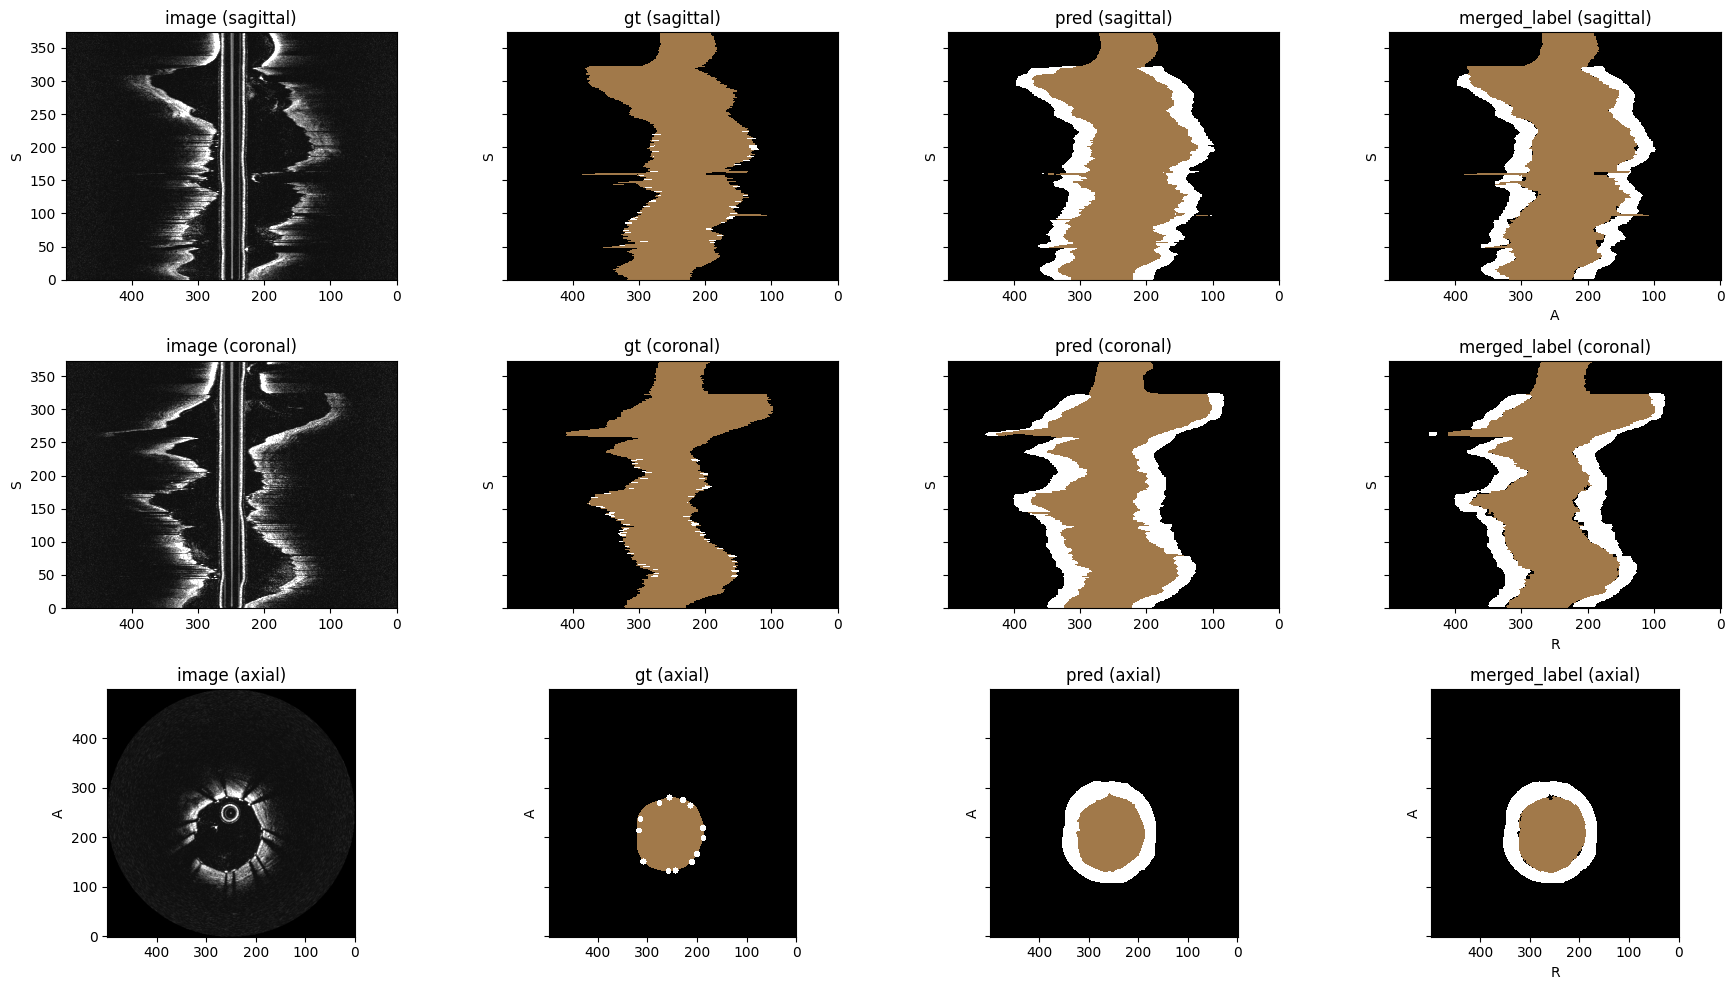

STENT_0004_0000.nii.gz STENT_0004.nii.gz STENT_0004.nii.gz


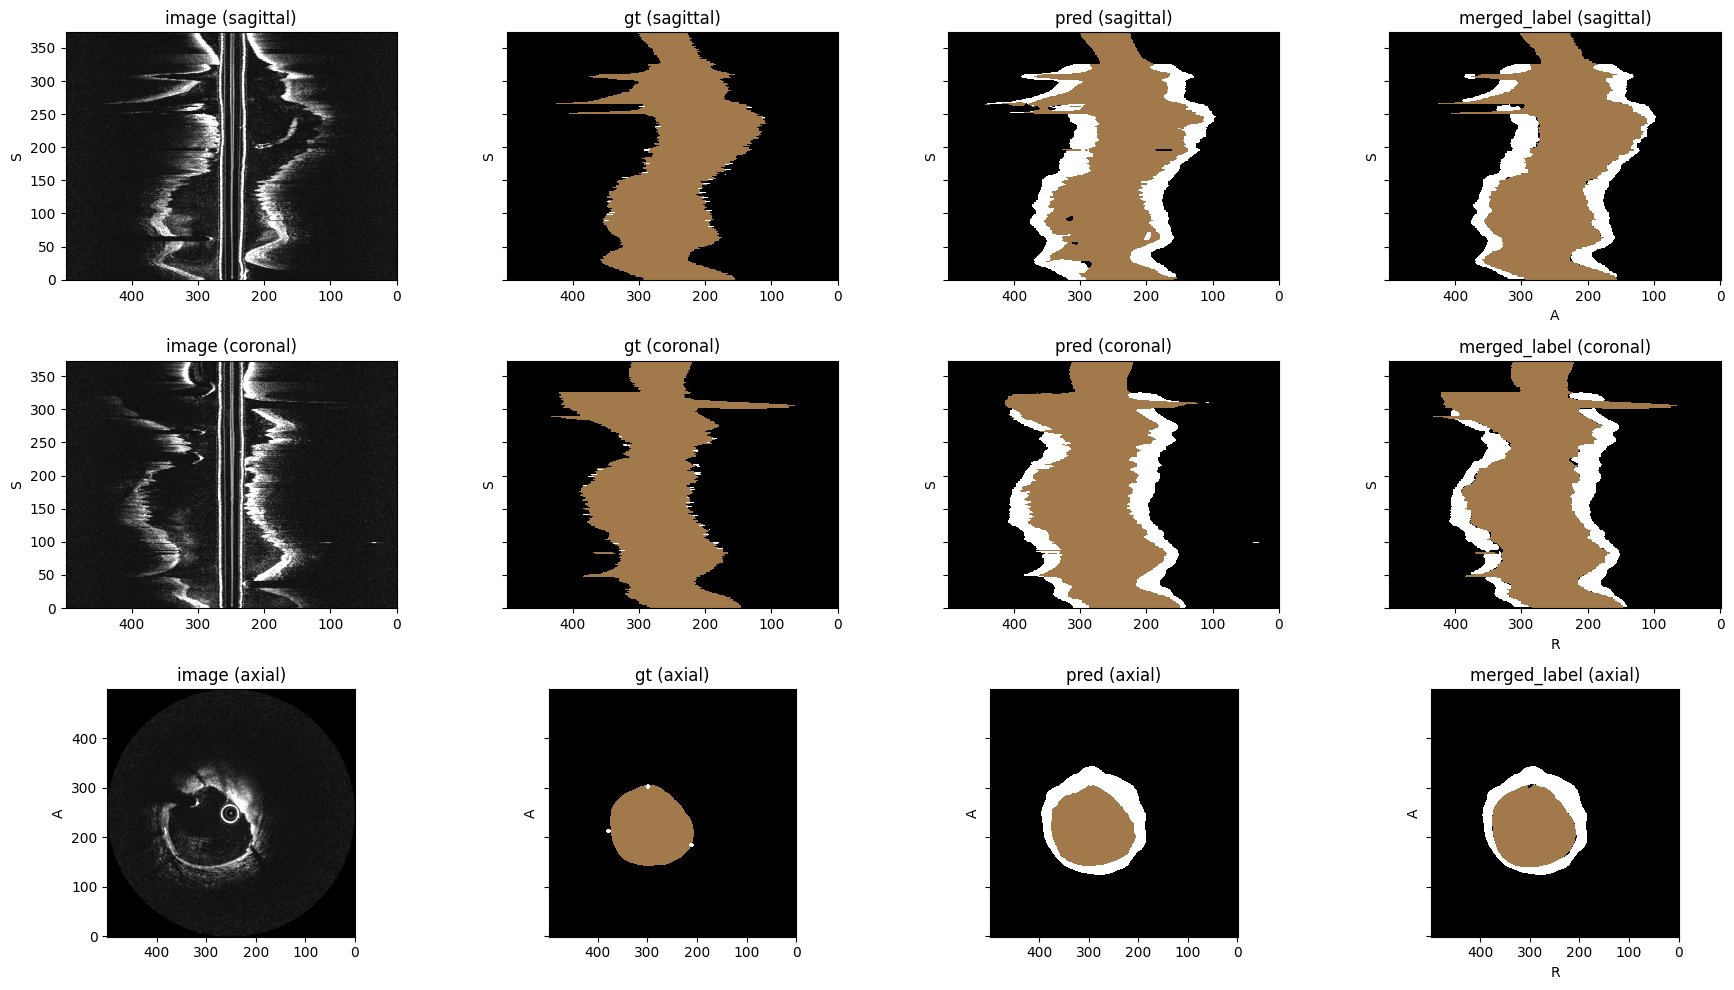

In [16]:
def morph_open(volume, structuring_element, iterations=1):
    for _ in range(iterations):
        volume = binary_erosion(volume, structuring_element)
        volume = binary_dilation(volume, structuring_element)
    return volume

def morph_close(volume, structuring_element, iterations=1):
    for _ in range(iterations):
        volume = binary_dilation(volume, structuring_element)
        volume = binary_erosion(volume, structuring_element)
    return volume

def create_elipsoidal_structure(radius_x, radius_y, radius_z):
    # Create a grid of the appropriate size
    r_max = max(radius_x, radius_y, radius_z)
    L = np.arange(-r_max, r_max+1)
    X, Y, Z = np.meshgrid(L, L, L)
    
    # Calculate the distance from the center
    distance = (X/radius_x)**2 + (Y/radius_y)**2 + (Z/radius_z)**2
    
    # Create the elipsodal structuring element
    structure = distance <= 1
    return structure

def merge_labels(gt: np.array, pred: np.array) -> np.array:
    W,H,D = gt.shape
    W,H,D = pred.shape

    # pred 1 lumen 2 wall
    # gt 1 lumen 2 stent
    gt = gt.copy() # deference
    gt[gt == 2] = 0 # remove stent label
    # closing small hole caused by remove stents
    structure = create_elipsoidal_structure(1, 1, 2)
    gt_lumen = morph_close(gt == 1, structure)
    gt[gt_lumen] = 1
    result = gt.copy()
    
    pred_wall = pred == 2
    structure = create_elipsoidal_structure(1, 1, 2)
    # remove noise
    pred_wall = morph_open(pred_wall, structure)
    # closing small hole
    pred_wall = morph_close(pred_wall, structure)

    result[pred_wall] = 2 # add wall prediction
    result[gt == 1] = 1 # any wall prediction overlapping gt's lumen annotation should be changed back to lumen

    return result[np.newaxis, ...]


for i, (nii_path, label_path, pred_path) in enumerate(zip(stent_input_dir_list, stent_label_dir_list, prediction_dir_list)):
    print(nii_path.name,pred_path.name, label_path.name)
    pred_label = subjects[pred_path.name].numpy()
    gt_label = subjects['gt_' + label_path.name].numpy()
    gt_label = np.rot90(gt_label[0].copy(), k=2, axes=(0, 1))[np.newaxis, ...].copy()
    merged_labels = merge_labels(gt_label[0], pred_label[0])
    nib.save(nib.Nifti1Image(merged_labels[0], np.eye(4)), stent_merged_label_dir / label_path.name)
    tio.Subject(
        image=subjects[nii_path.name],
        gt=tio.LabelMap(tensor=gt_label),
        pred=tio.LabelMap(tensor=pred_label.copy()),
        merged_label=tio.LabelMap(tensor=merged_labels)
    ).plot(figsize=(20, 10))


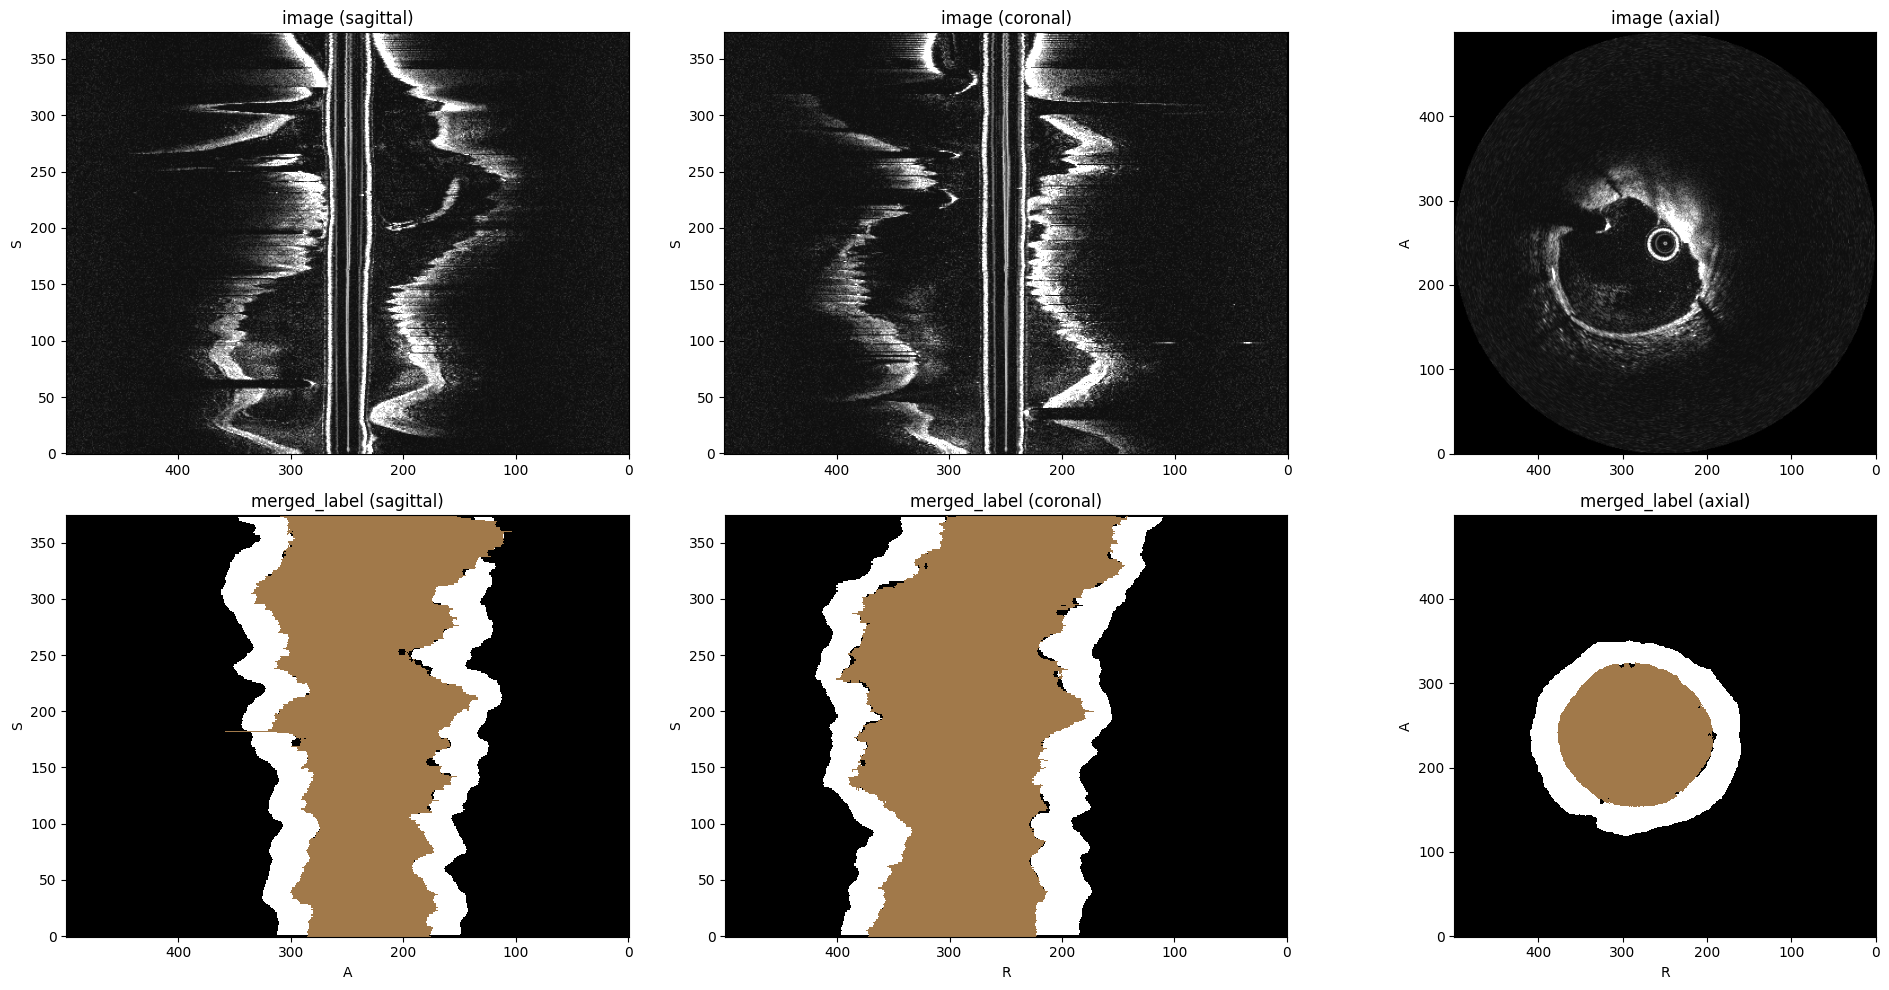

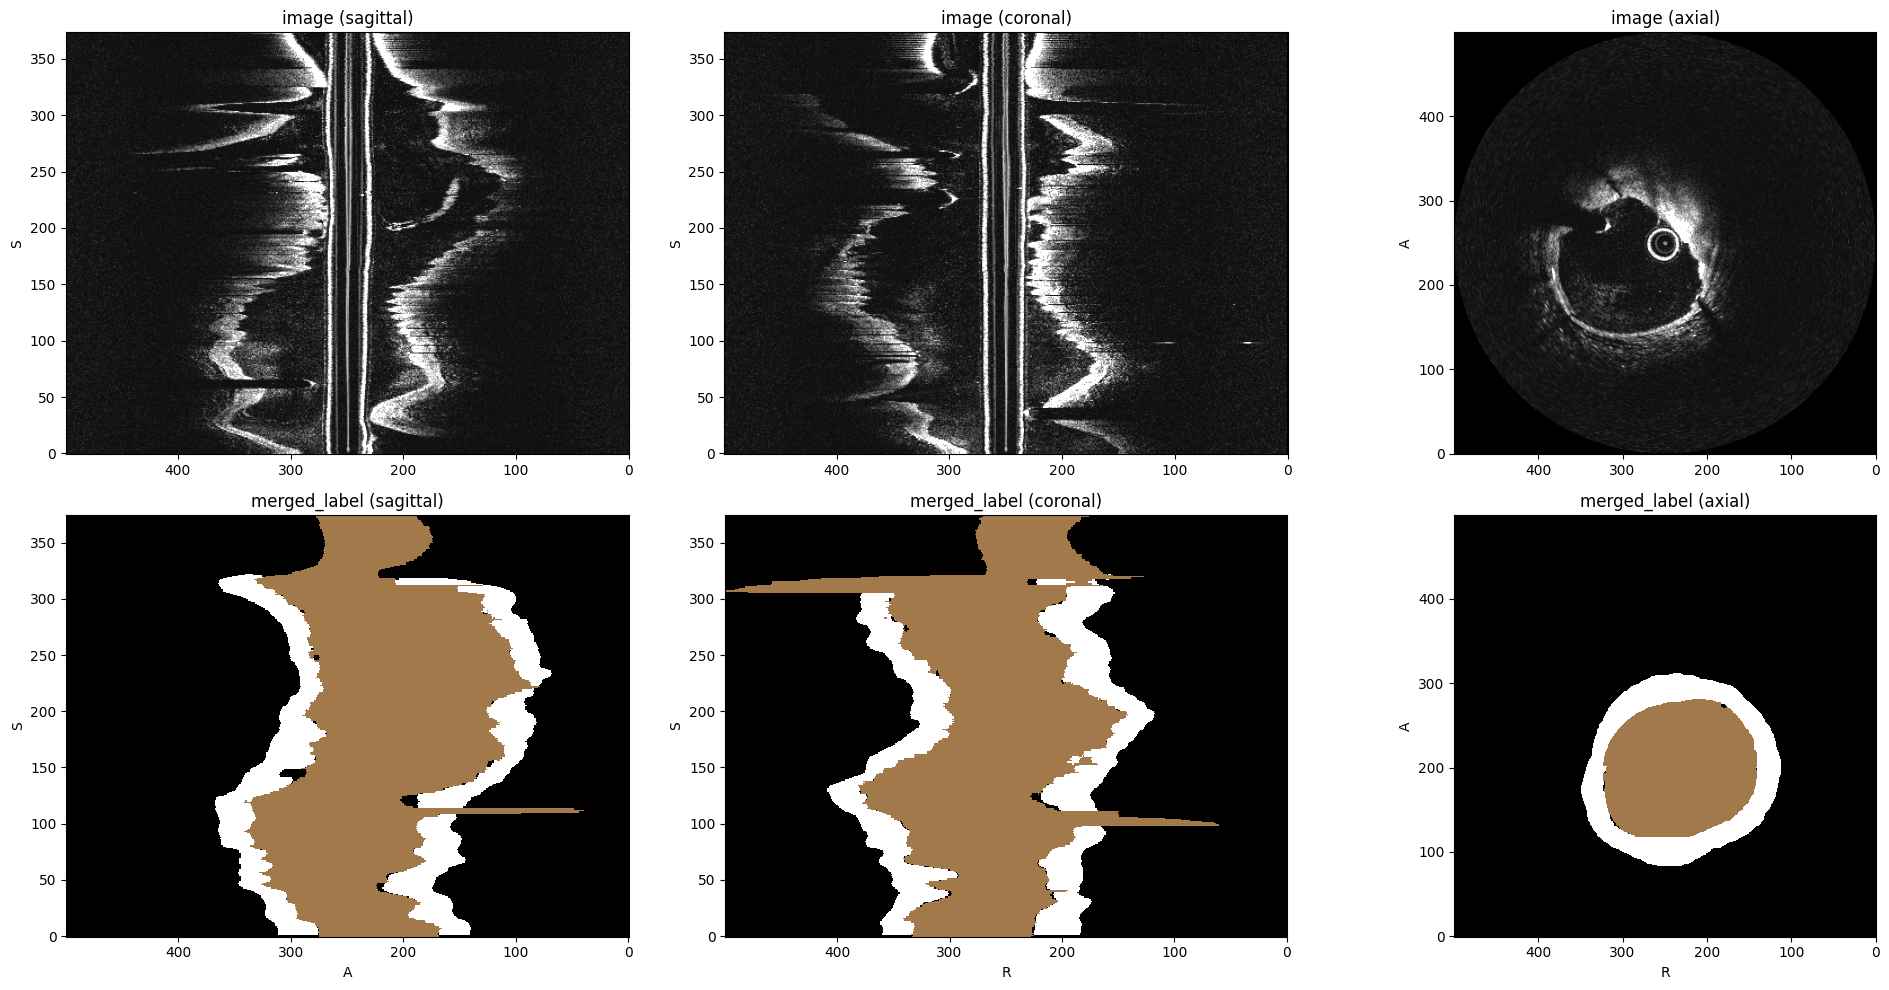

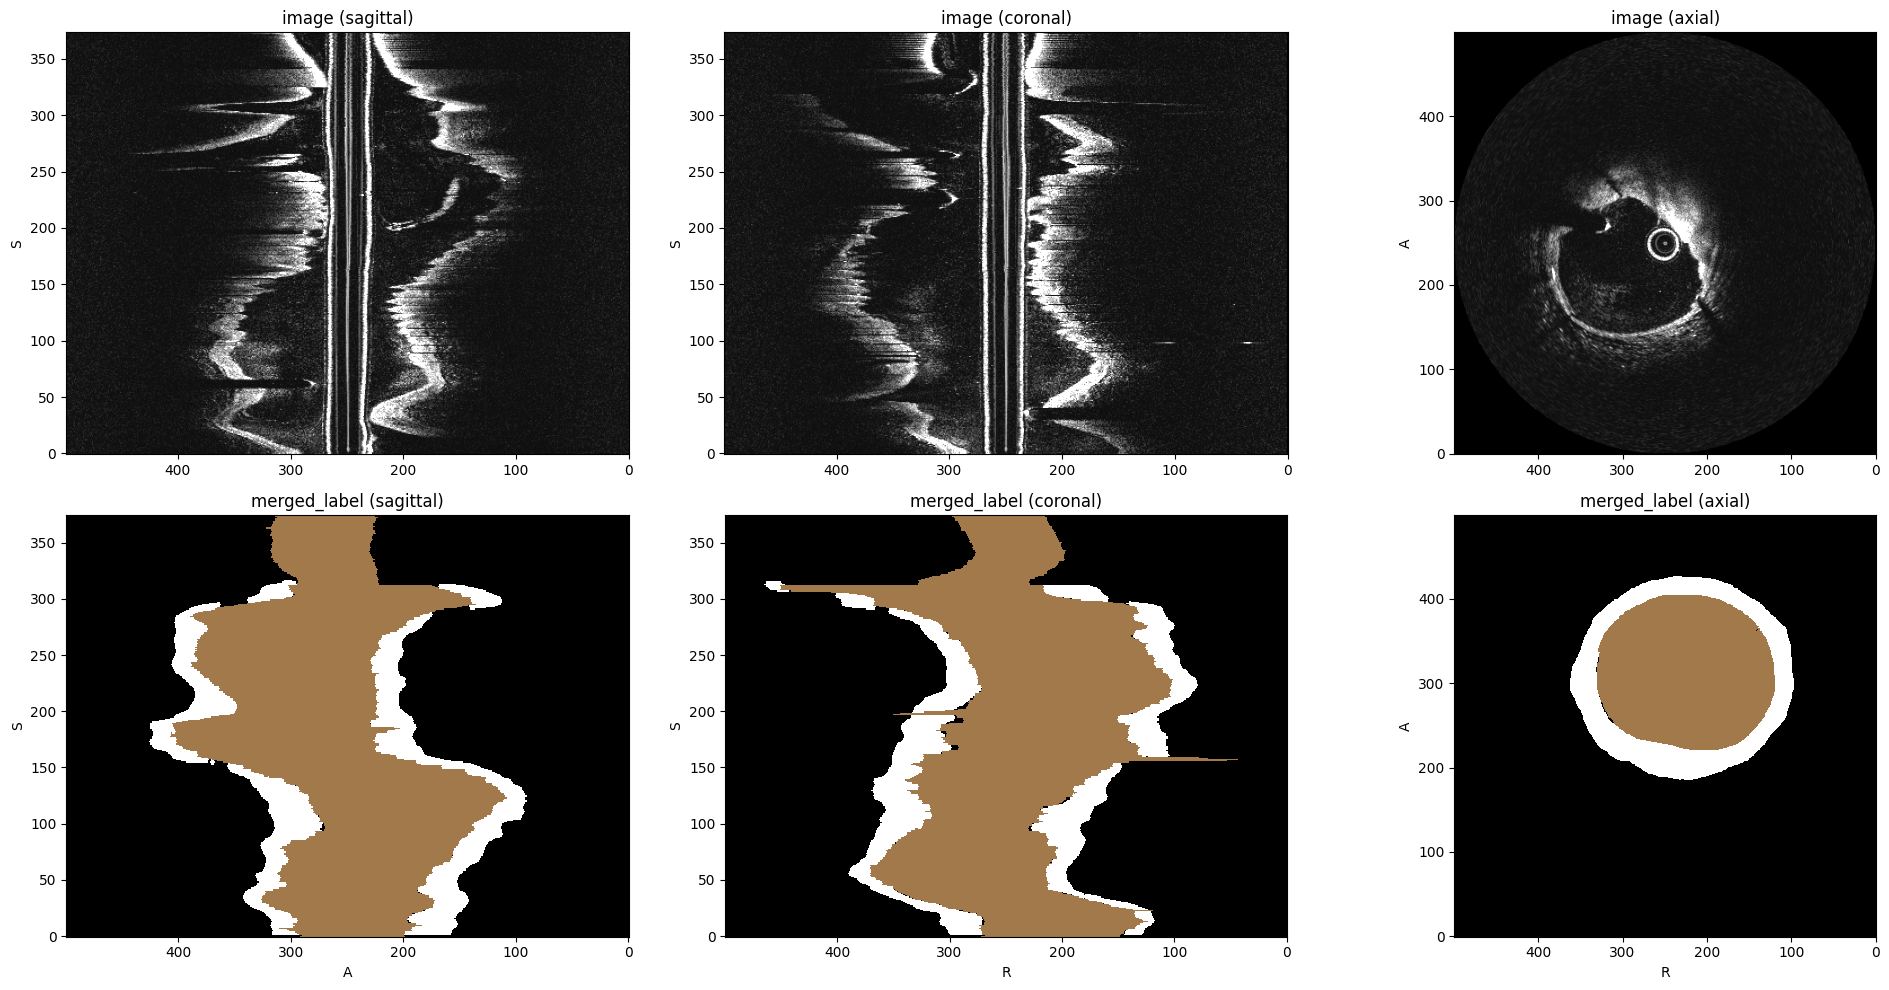

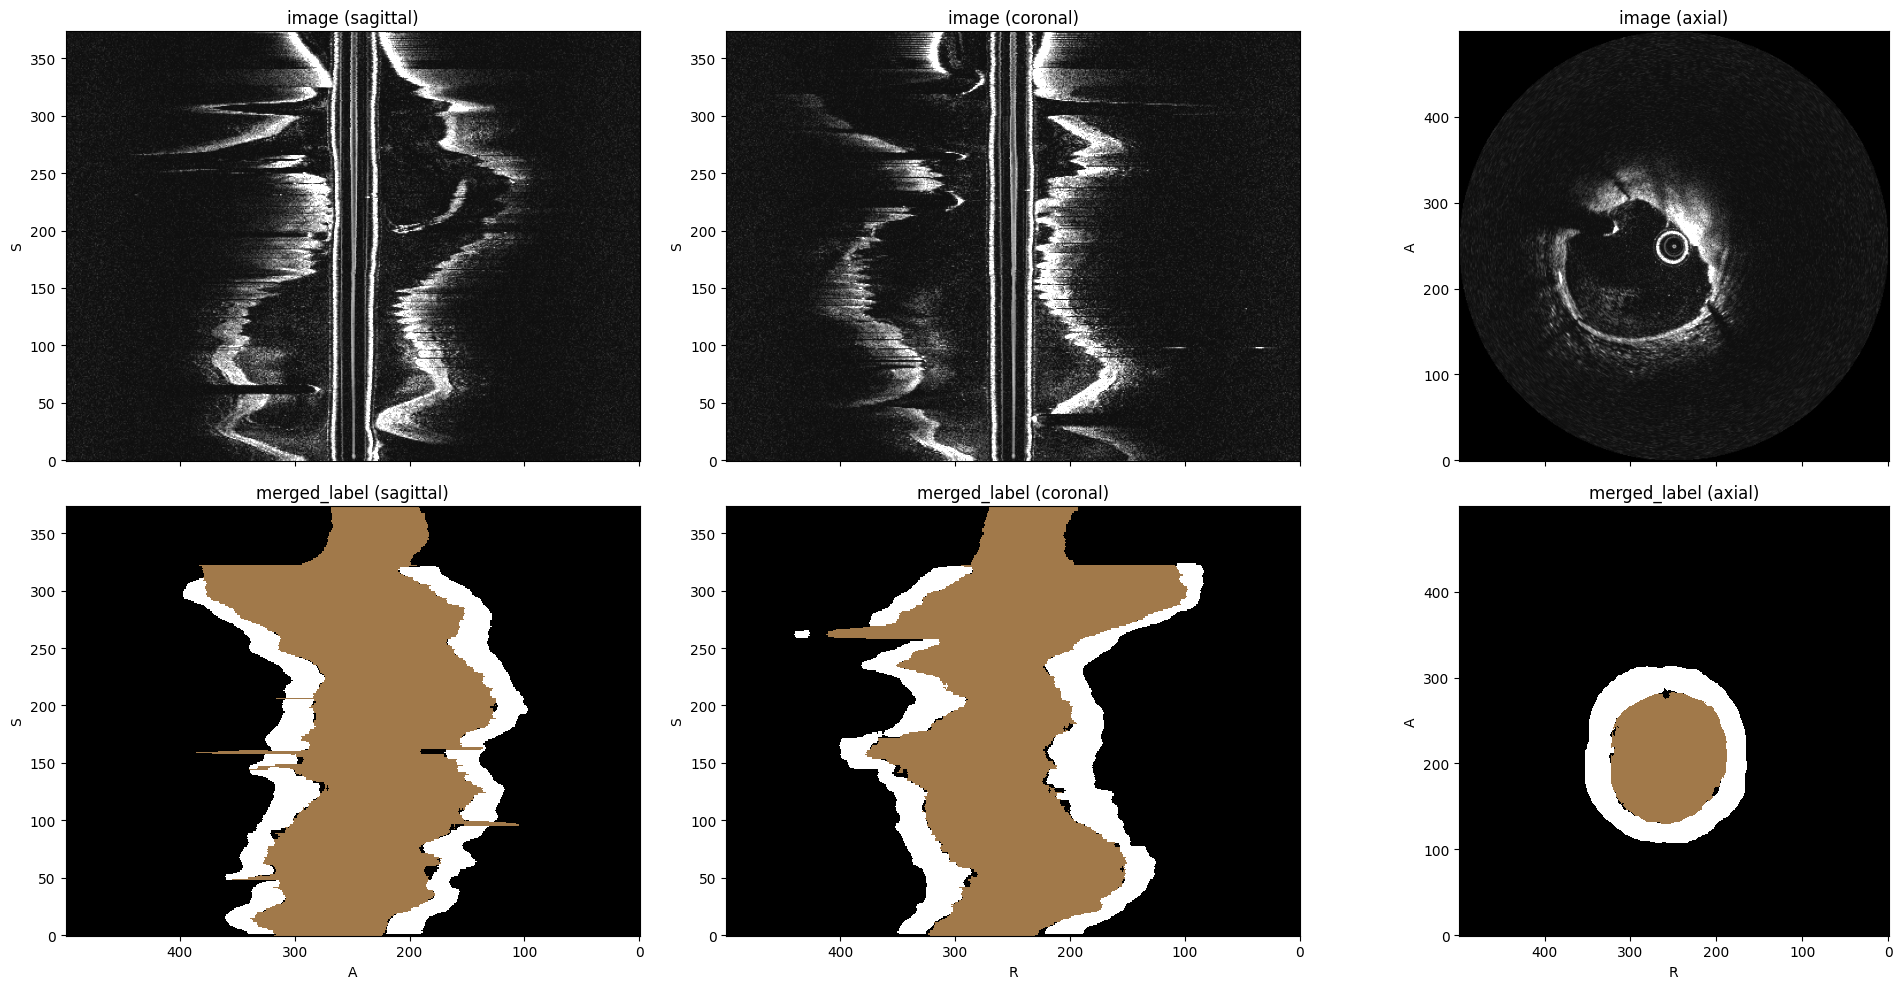

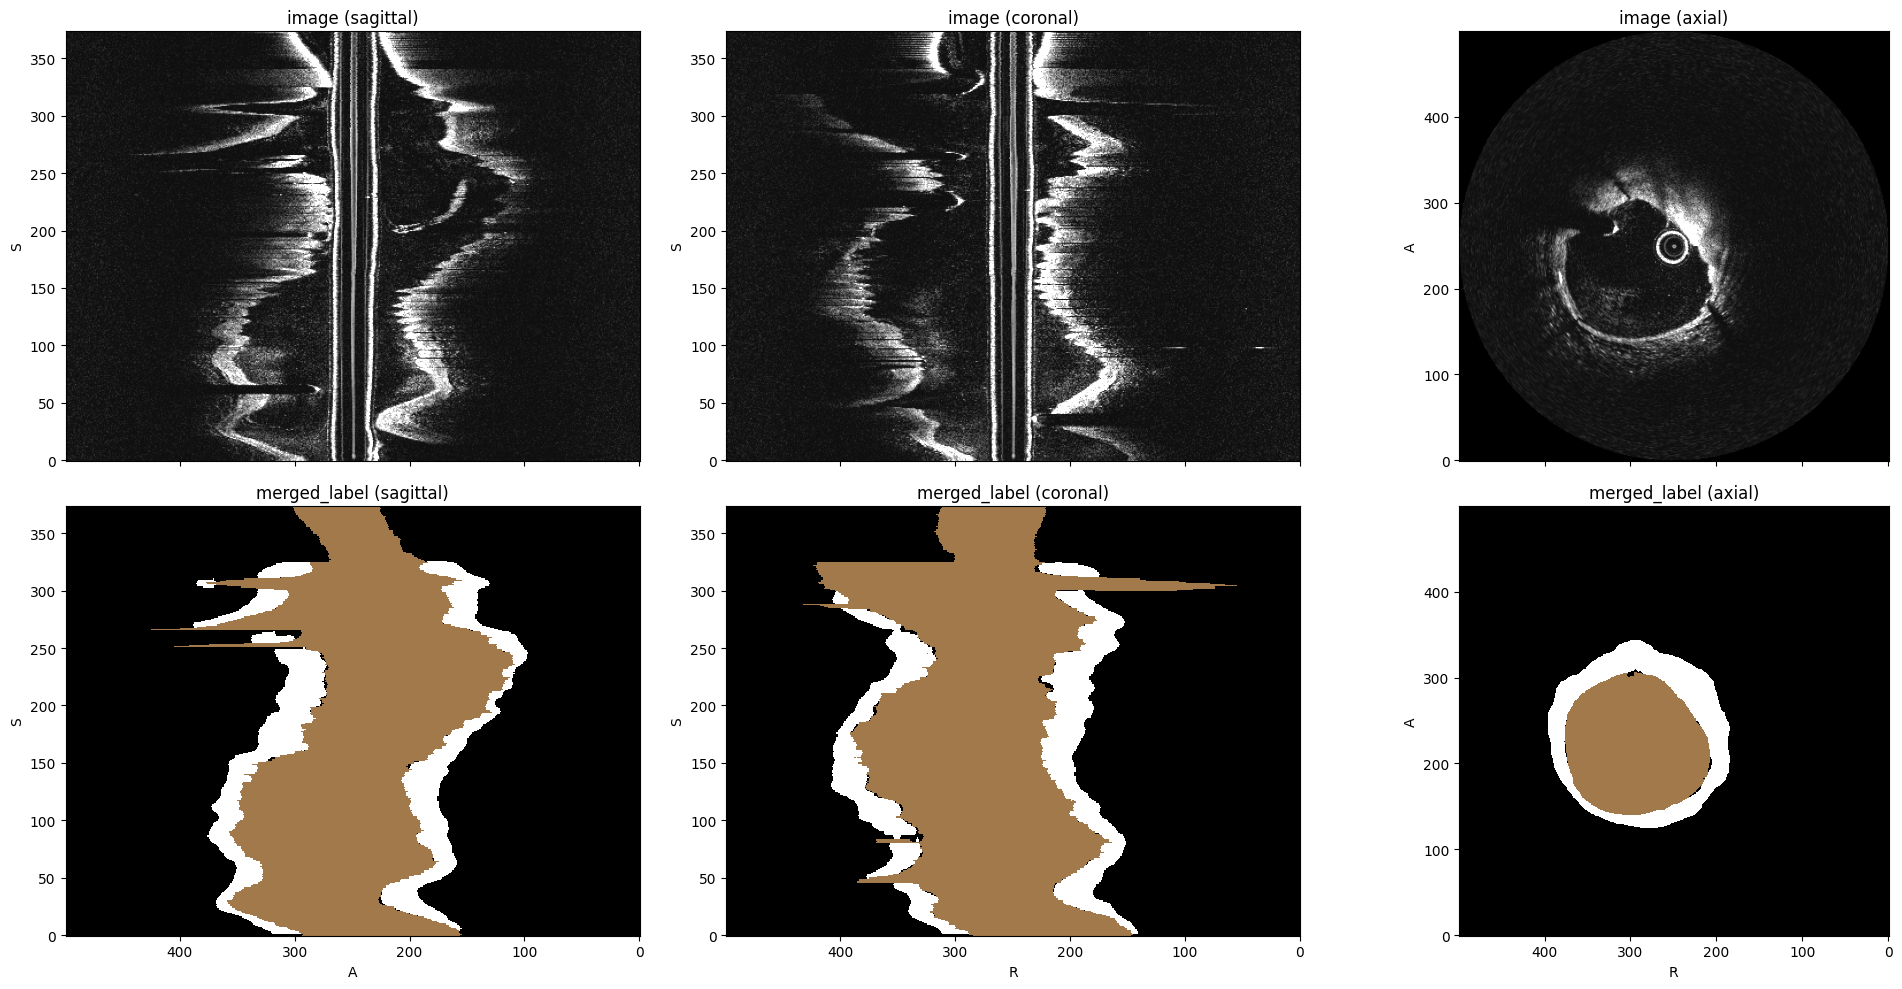

In [17]:
# One final visual check to see that the saved merged labels are correct

for label_path in stent_label_dir_list:
    tio.Subject(
        image=tio.ScalarImage(nii_path),
        merged_label=tio.LabelMap(stent_merged_label_dir / label_path.name)
    ).plot(figsize=(20, 10))